In [3]:
#MNIST 파일 받아오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys() # 사이킷런의 데이터셋들은 일반적으로 비슷한 딕셔너리 구조임.

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape) #70,000개의 이미지가 있고, 784개의 특성이 있음. 이미지가 28*28 픽셀로 구성돼있어서 784개의 특성. 개개의 특성은 0~255까지(흰색~검은색) 픽셀의 강도만 나타냄
print(y.shape)

(70000, 784)
(70000,)


<function matplotlib.pyplot.show(*args, **kw)>

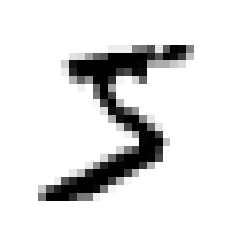

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28) #첫 번째 데이터에 저장된 이미지를 28*28 픽셀로 재형성해서 들고오는 거임.

plt.imshow(some_digit_image, cmap = "binary") #binary 형태로 데이터를 불러옴
plt.axis("off") #축 필요 없으니까 없애버리기.
plt.show # 숫자 5처럼 보임

In [17]:
#확인해보자
print(y[0]) # 5처럼 생겼는데 label에 5가 뜸

5


In [6]:
#숫자 출력 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [7]:
#label은 문자열로 돼있는데, 보통 머신러닝 할 때 숫자형 필요하니까 타입 바꾸기
import numpy as np
y = y.astype(np.uint8)

In [8]:
# ! 중요 ! 항상 데이터셋을 자세히 보기 전에 테스트 세트를 따로 뺄 것!

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#MNIST DATA SET의 경우에는 아예 앞쪽 60000개는 훈련, 그 뒤의 10000개는 테스트용으로 쓰라고 나뉘어져 있음
#훈련 데이터셋은 심지어 이미 랜덤으로 잘 섞어놔서 교차 검증 폴드를 다 비슷하게 만들 수 있도록 해놨음!
#이렇게 잘 정제된 데이터를 사용하는 경우가 아니라면 당연히 sklearn.train_test_split요거로 적절하게 나누고 train data set은 잘 섞어서 훈련시켜야 함!
#물론, 주가, 부동산 가격 등 시계열 분석이 필요한 경우는 섞으면 큰일나겠죠?

In [21]:
#이진 분류기 훈련(이진 분류기 : 맞게, 아니게?)
#타깃 벡터 생성하기
y_train_5 =(y_train ==5) # 5는 true고 나머지는 모두 False가 나오는 거임.
y_test_5 = (y_test == 5)

#SGD(Stochastic Gradient Descent, 확률적 경사 하강법)로 훈련
#이 모델은 매우 큰 데이터셋을 효율적으로 처리하는 데 강점을 가지고 있음.
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
#예측
sgd_clf.predict([some_digit]) #some_digit이 5입니다.

array([ True])

In [23]:
#성능지표를 측정하자!

In [24]:
#1 교차검증을 사용한 정확도 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")
#k-fold cross validation은 훈련세트를 k개의 폴드로 나누고 각 폴드에 예측을 만들고 평가하는 방식으로 성능을 평가함.

# 5 아님 클래스로 분류하는 더미 분류기를 만들어보자.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [25]:
## 조금 더 엄격한 규제를 적용해서 만들고 싶다면!
#매 반복에서 분류기 객체를 복사하여 훈련 폴드를 훈련시키고 테스트 폴드로 예측
from sklearn.model_selection import StratifiedKFold #클래스별 비율이 유지되도록 폴드를 만듦.
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
# 5아님으로만 예측해도 90이 넘는 성능지표가 나옴! -> 불균형데이터! -> 성능지표로 accuracy를 쓰면 안 됨! 

0.95035
0.96035
0.9604


In [26]:
np.zeros((5,1), dtype=bool)

array([[False],
       [False],
       [False],
       [False],
       [False]])

In [27]:
#2. 오차 행렬 만들어 분석하기
# 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
#EX. 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 -> 오차 행렬의 5행 3열을 확인
# 오차행렬을 만들기 위해서는 실제 타깃과 비교할 수 있도록 예측값을 우선 만들어야 함.
# 당연히 테스트 세트는 사용하면 안 됨!

from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#각 테스트 폴드에서 얻은 예측을 반환!

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #타깃 클래스: y_train_5, 예측 클래스: y_train_pred

#수치 해석
##행은 실제클래스, 열은 예측클래스를 의미
##1행은 5가 아닌 것을 5가 아닌 것으로 옳게 분류했느냐!(Negative Class) 1행1열은 5가 아닌 것을 5가 아닌 것으로 분류한 것(True Negative), 1행 2열은 5가 아닌 것을 5로 잘못분류한 경우(False Positive)
## 2행은 5인 것을 5라고 제대로 분류했느냐!(Positive Class) 2행 1열은 5인 것을 5가 아니라고 분류한 것(False Negative), 2행 2열은 5인 것을 5라고 제대로 분류한 것(True Positive)

#조금 더 요약된 지표가 정밀도(Precision) = TP/(TP+FP)이지만, 확실한 양성 샘플 하나만 예측하면 간단히 완벽한 정밀도를 획득가능하기 때문에 정밀도는 재현율(Recall, 또는 민감도(Sensitivity), 진짜양성비율(True Positive Ratio)) = TP/(TP+FN)과 함께 쓰임.

#정밀도는 양성 예측을 얼마나 정확하게 했는가!(양성이라 나온 것들 중에서 진짜 양성이 얼마나 되는데?)
#재현율은 분류기가 정확하게 감지한 양성샘플의 비율(전체 양성 샘플에서 얘가 양성이라고 제대로 뽑은 건 얼마나 됨?)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [29]:
#3.정밀도와 재현율
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5, y_train_pred))

#F1 Score(정밀도와 재현율의 조화평균, 두 분류기를 비교할 때 쓰면 좋음) = 2*(정밀도*재현율)/(정밀도+재현율)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8370879772350012
0.6511713705958311


0.7325171197343846

[2164.22030239]
[ True]
[False]


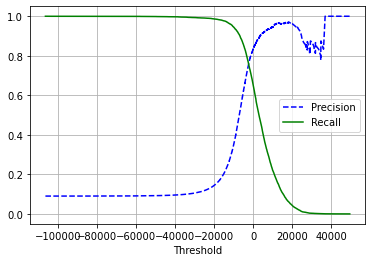

In [30]:
#정밀도와 재현율의 trade_off
#F1 score는 정밀도와 재현율이 비슷할수록 큰 값이 나옴.
#정밀도와 재현율은 역의 관계임! 정밀도를 올리면 재현율은 떨어질 수밖에 없음 -> Trade-Off
#목적에 맞는 성능 측정 지표를 활용해야 한다.

y_scores = sgd_clf.decision_function([some_digit]) #이 점수가 sgd_classifier에서의 샘플의 점수임!
print(y_scores)

#임계값 설정하기
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

#임계값을 높이면?
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

##Conclusion: 임계값이 높아지면 재현율은 낮아짐!(Note: some_digit은 5인 이미지 샘플!)
##적절한 임계값을 구하기 위해: cross_val_predict로 훈련세트에 있는 모든 샘플의 점수를 구함

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "precision")
    plt.plot(thresholds, recalls[:-1],"g-",label = "recall")
    plt.xlabel('Threshold')
    plt.legend(["Precision","Recall"])
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

#정밀도 곡선이 재현율 곡선보다 더 울퉁불퉁한 이유는 임곗값을 올리더라도 정밀도가 떨어지는 경우도 존재하기 때문! 반면 재현율은 임곗값이 올라가면 낮아질 수밖에 없어서 부드러운 곡선이 나옵니다.

In [31]:
#최소한 90%이상의 정밀도를 갖게하는 임계점 찾기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #np.argmax 는 최댓값의 첫 번째 인덱스를 반환
print(threshold_90_precision)
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

#재현율이 너무 낮으면 곤란!

3370.0194991439594
0.9000345901072293
0.4799852425751706


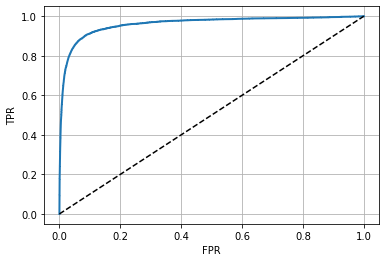

0.9604938554008616

In [32]:
#4. ROC곡선: 거짓양성비율(FPR)에 대한 진짜양성비율(재현율, TPR) 곡선
# FPR = 1 - TNR(진짜음성비율, 특이도(Specificity))
# ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #대각 점선: 완전한 랜덤 분류기의 ROC Curve
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid()
plot_roc_curve(fpr, tpr)
plt.show()

#재현율(TPR)이 높을수록 FPR(거짓양성)이 늘어남.
#좋은 분류기일수록 대각점선에서 좌상단으로 멀어져야 함.
#곡선 아래의 면적(Area Under the Curve)을 측정하면 분류기들을 비교할 수 있음. 완벽한 분류기는 AUC가 1, 완전 랜덤 분류기는 0.5

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)
#일반적으로 양성클래스가 드물거나 거짓음성보다 거짓양성이 더 중요할 때 PR곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용함.

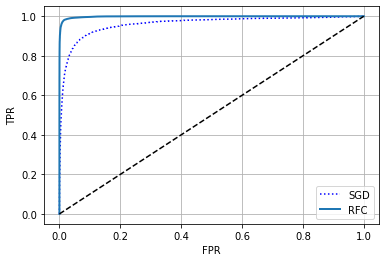

In [33]:
#RandomForestClassifier 분류기와 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = "predict_proba")
#randomforestclassifier는 "decision_function()" 메소드가 없기 때문에 비슷한 역할을 하는 "predict_proba" method를 활용하는 거
#predict_proba method는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 출력함.
# print(y_probas_forest)
y_scores_forest = y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 활용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RFC")
plt.legend(loc="lower right")
plt.show()
#rfc 그래프가 좌상단에 위치하므로 더 좋은 분류기라는 것을 알 수 있음!

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
#이진 분류기의 조합으로 다중분류 실행하기
# OvR 방식: 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련 -> 클래스가 10개인 숫자 이미지 분류 시스템 생성/ 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
# OVO 방식: 0과 1 구별, 0과2 구별, 1과2 구별 등과 같이 각 숫자의 조합마다 이진분류기를 훈련.

#SVM과 같은 훈련 세트의 크기에 민감해서 작은 훈련 세트에서 많은 분류기를 훈련시키는 경우 -> OvO
#대부분의 경우 OvR 선호

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) #다중분류이기 때문에 이제 5만 분류할 필요가 없어졌음 -> y_train 사용
svm_clf.predict([some_digit])
#내부에서 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택.

array([5], dtype=uint8)

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]


In [37]:
#OvO나 OvR 방식 강제하기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


In [24]:
#결괏값 확인 및 검증
sgd_clf.decision_function([some_digit]) # class 5가 가장 높은 점수를 기록하고 있지만, 3 역시 조금은 의심하고 있음을 알 수 있음.
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [25]:
#성능 UPGRADE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) #입력변수 scaling
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [26]:
# 오차 행렬을 통해 에러의 종류를 분석하고 성능 향상시키기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) #cross_val_predict 함수로 예측을 만듦
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

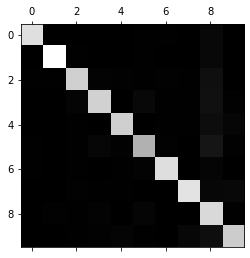

In [27]:
#오차행렬 그림으로 표현해서 빠르게 확인하기
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()
#대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있음.
#숫자 5가 다른 숫자보다 조금 더 어두워 보이는데, 이건 숫자 5의 데이터셋이 충분하지 않거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻임.

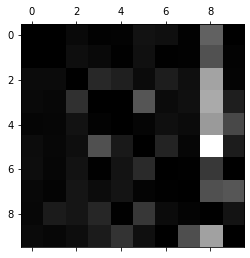

In [28]:
#그래프의 에러에 초점 맞추기
#오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
#에러 개수로 비교하면 이미지가 많은 클래스의 에러 개수가 많은 경우가 다반사니까!

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

#다른 항목은 유지, 주대각선만 0으로 채워서 그래프 그리기
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

#행은 실제 클래스, 열은 예측 클래스임을 명심!
#클래스 8의 열이 밝다? -> 많은 이미지들을 8로 분류해버린 거임!
#근데 정작 (8,8)은 검은색? -> 8은 8이라고 잘 분류한 거 맞음!
#3이랑 5는 모델이 헷갈려하고 있음
# => 8로 잘못분류되는 현상을 줄이자.

In [33]:
#개개의 에러 분석하기!(3과 5의 샘플 분류를 바탕으로 확인해보자)
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], image_per_row =5)
plt.subplot(222); plot_digits(X_ab[:25], image_per_row =5)
plt.subplot(223); plot_digits(X_ba[:25], image_per_row =5)
plt.subplot(224); plot_digits(X_bb[:25], image_per_row =5)
#왼쪽 두 개는 3으로 분류된 이미지, 오른쪽 두 개는 5로 분류된 이미지
#에러의 원인은 선형모델인 SGDClassifier를 사용하기 때문!
#선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산.  3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 혼동하는 것.
#3과 5의 주요 차이는 위쪽 선과 아래 호를 이어주는 작은 직선의 위치
#따라서 3이 조금만 왼쪽으로 치우쳐있어도 분류기가 5로 분류해버리는 거임!
#그러므로 해결책은 이미지를 중앙에 고정시키도록 데이터를 전처리하는 것.

AttributeError: 'AxesImage' object has no property 'image_per_row'

In [10]:
# 다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
#각 숫자 이미지에 두 개의 타깃레이블이 담긴 y_multilabel 배열을 만듦

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [11]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [12]:
#성능 지표:많음, 프로젝트에 따라 다름. 여기서는 F1 score 확인해보자
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro") #단순 산술평균임. 샘플 수에 따라 가중치를 두려면 weighted로 average를 바꿔주면 됨.
#F1 score = 정밀도와 재현율의 조화평균 : 정밀도와 재현율이 비슷할수록 높은 값.

NameError: name 'cross_val_predict' is not defined

In [13]:
#다중 출력 분류
#noise 제거해서 출력하는 시스템으로 예시를 들어보자!
some_index = 0
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise #픽셀 강도에 잡음 추가
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'plot_digit' is not defined

In [9]:
#연습문제 1
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
KNB_clf = KNeighborsClassifier()
param_grid = {'weights' : ['uniform','distance'],
'n_neighbors':[3,5,7,9]}
Optimizer = GridSearchCV(KNB_clf, param_grid,cv=3, scoring = 'accuracy', return_train_score = True)

Optimizer.fit(X_train, y_train)
Optimizer.best_params_


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = Optimizer.predict(X_test)
Optimizer.accuracy_score(y_test, y_pred)

In [ ]:
#연습문제 2

In [ ]:
def shift_one_pixel(image, dx, dy):
    image = image.reshape(28,28)
    shifted_image = shift(image, [dx,dy])
    return shifted_image.reshape([-1])

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]
for dx, dy in ((-1,0),(1,0),(0,-1),(0,1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_one_pixel(image,dx,dy))
        y_train_augmented.append(label)
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

knn_clf = KNeighborsClassifier(**Optimizer.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

